# Predictions vs References: Performance evaluation (ASR & Diarization)

In [4]:
import csv
import shutil
import os
import pandas as pd

from metrics_helpers import process_folder, load_data_time, compute_der

import sys
sys.path.append('..')  # Adds the parent directory to the path
from audio_and_experiment.format_helpers import get_files

### Preparing evaluation folder (Predictions vs References)

In [2]:
directories = ['../results/Compassion', '../results/OBE1', '../results/OBE2'] # The csv file that you want to compare
pred_folder = '../performance_evaluation/predictions' # Specify the name if trying to compare different models of ASR & Diarization

def copy_csv_files(directories, pred_folder):
    pred_files = []
    for directory in directories:
        pred_files.append(get_files(directory, 'csv'))
    pred_files = [item for sublist in pred_files for item in sublist]

    os.makedirs(pred_folder, exist_ok=True)
    for file in pred_files:
        shutil.copy(file, pred_folder)

#copy_csv_files(directories, pred_folder)

### ASR and Diarization metrics + Visual Tool to be better compare & understand

In [7]:
# Hands-on parameters to better estimate the performance of the ASR system, as the diariasation task may skip whole sentences worse unfairly the WER metric
max_insert_length = None # Exclude insertions longer than 3 words from the WER calculation

prediction_folder = "../../performance_evaluation/predictions"
reference_folder = "../../performance_evaluation/references"

# Provide the orignal length of the audio file, 
# Without this it only have the interval of speech detected by the model, therefore worsen the DER metric
orignal_info = pd.read_csv("../audio_and_experiment/audio_data.csv")

metric = process_folder(prediction_folder, reference_folder, max_insert_length, info=orignal_info)
metric.to_csv('../../performance_evaluation/metrics.csv', index=False)

Processing file: ID 05.csv
Combined HTML file saved as ../../performance_evaluation/predictions\visual_comparison\ID 05_Diarization.html
Processed file: ID 05.csv
Processing file: Id 08.csv
Combined HTML file saved as ../../performance_evaluation/predictions\visual_comparison\Id 08_Diarization.html
Processed file: Id 08.csv
Processing file: Id 13.csv
Combined HTML file saved as ../../performance_evaluation/predictions\visual_comparison\Id 13_Diarization.html
Processed file: Id 13.csv
Processing file: Id 13b.csv
Combined HTML file saved as ../../performance_evaluation/predictions\visual_comparison\Id 13b_Diarization.html
Processed file: Id 13b.csv
Processing file: Id 14.csv
Combined HTML file saved as ../../performance_evaluation/predictions\visual_comparison\Id 14_Diarization.html
Processed file: Id 14.csv
Processing file: Id 15.csv
Combined HTML file saved as ../../performance_evaluation/predictions\visual_comparison\Id 15_Diarization.html
Processed file: Id 15.csv
Processing file: Id

### (Optional) Dialogue DER Analysis in CSV instead than in HTML

In [6]:
def dialgue_DER(reference_file, prediction_file, output_file):
    df_ref, df_pred = load_data_time(reference_file, prediction_file)
    dialogue_df, error_durations = compute_der(df_ref, df_pred)

    # Display error durations and DER
    print("\nError Durations and DER:")
    for key, value in error_durations.items():
        if key == 'DER':
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.3f} seconds")

    # Optionally, save the DataFrame to a CSV file
    dialogue_df.to_csv(output_file, index=False)

In [7]:
reference_file = '../S301final_C.csv'
prediction_file = '../S301final.csv'
output_file = 'dia_S301final.csv'

dialgue_DER(reference_file, prediction_file, output_file)


Error Durations and DER:
DER: 7.18%
Reference Speech Duration: 342.280 seconds
Missed Duration: 1.060 seconds
False Alarm Duration: 0.260 seconds
Confusion Duration: 23.240 seconds


## Visualize global metrics

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_none = pd.read_csv('../performance_evaluation/metrics_max_insert_none.csv')
df_4 = pd.read_csv('../performance_evaluation/metrics_max_insert_4.csv')

In [6]:
def plot_wer_vs_der_scatter(df):
    """
    Plots a scatter plot of WER vs. DER.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='WER', y='DER', hue='Filename', palette='viridis', s=100 , legend=False)
    
    plt.xlabel('Word Error Rate (WER)')
    plt.ylabel('Diarization Error Rate (DER)')
    plt.title('Scatter Plot of WER vs. DER')
    plt.tight_layout()
    plt.show()

def plot_histograms(df):
    """
    Plots histograms for WER and DER distributions.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(12, 6))
    
    # Histogram for WER
    plt.subplot(1, 2, 1)
    ax1 = sns.histplot(df['WER'], bins=10, kde=True, color='skyblue')
    plt.xlabel('Word Error Rate (WER)')
    plt.title('Distribution of WER')

    # Calculate total number of valid WER entries
    total_wer = df['WER'].dropna().shape[0]

    # Annotate each bar with percentage
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            percentage = (height / total_wer) * 100
            ax1.annotate(f'{percentage:.1f}%', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')
    
    # Histogram for DER
    plt.subplot(1, 2, 2)
    ax2 = sns.histplot(df['DER'], bins=10, kde=True, color='salmon')
    plt.xlabel('Diarization Error Rate (DER)')
    plt.title('Distribution of DER')

    # Calculate total number of valid DER entries
    total_der = df['DER'].dropna().shape[0]
    
    # Annotate each bar with percentage
    for p in ax2.patches:
        height = p.get_height()
        if height > 0:
            percentage = (height / total_der) * 100
            ax2.annotate(f'{percentage:.1f}%', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')
    
    plt.tight_layout()
    plt.show()

def plot_boxplots(df):
    """
    Plots box plots for WER and DER.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(8, 4))
    
    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = df.melt(id_vars='Filename', value_vars=['WER', 'DER'], var_name='Metric', value_name='Value')
    
    sns.boxplot(x='Metric', y='Value',hue="Metric" ,data=melted_df, palette=['skyblue', 'salmon'])
    
    plt.title('Box Plots of WER and DER')
    plt.xlabel('Metric')
    plt.ylabel('Error Rate')
    
    plt.tight_layout()
    plt.show()

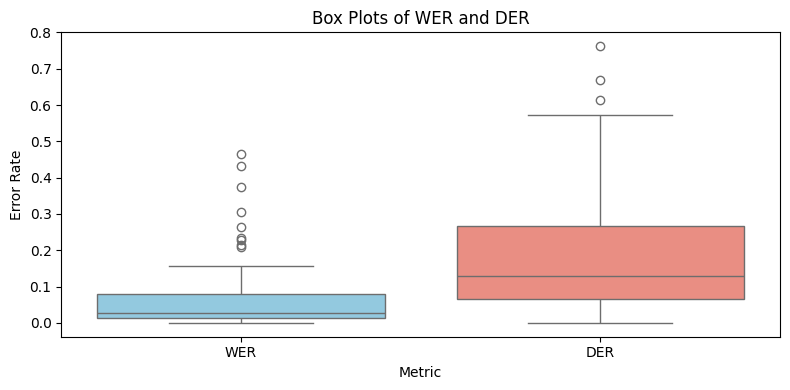

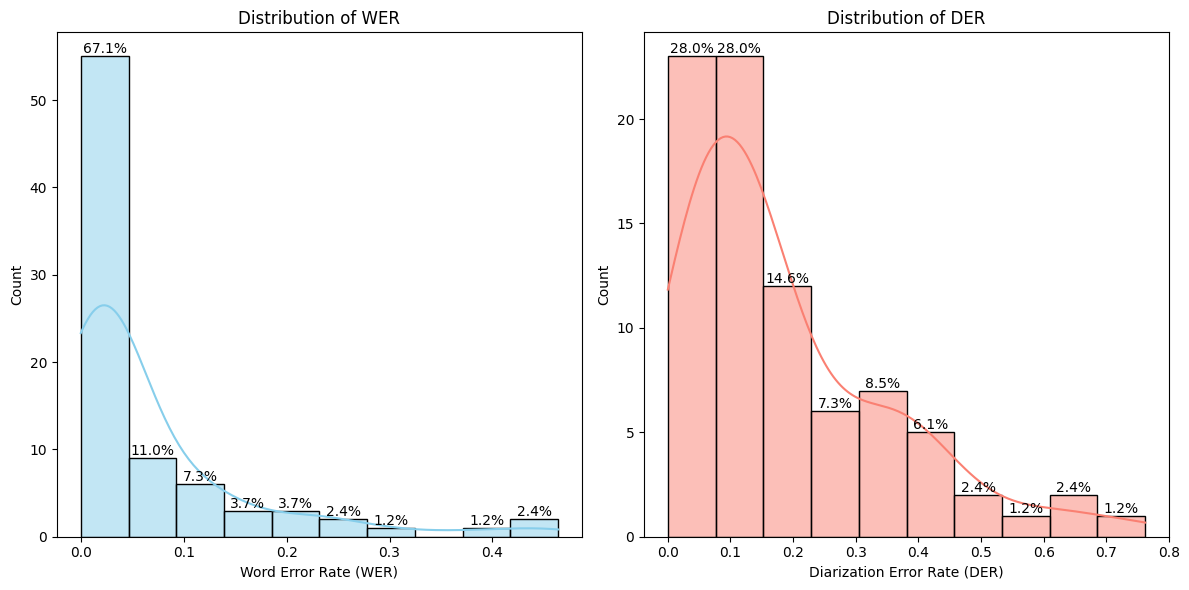

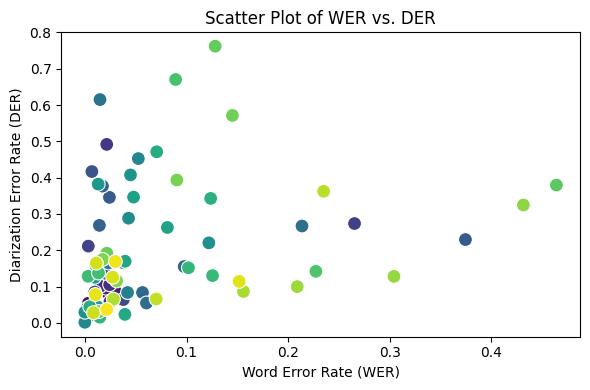

In [7]:
plot_boxplots(df_none)
plot_histograms(df_none)
plot_wer_vs_der_scatter(df_none)

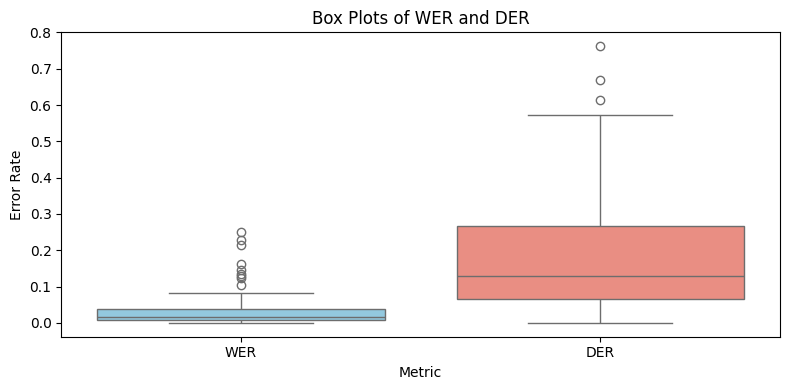

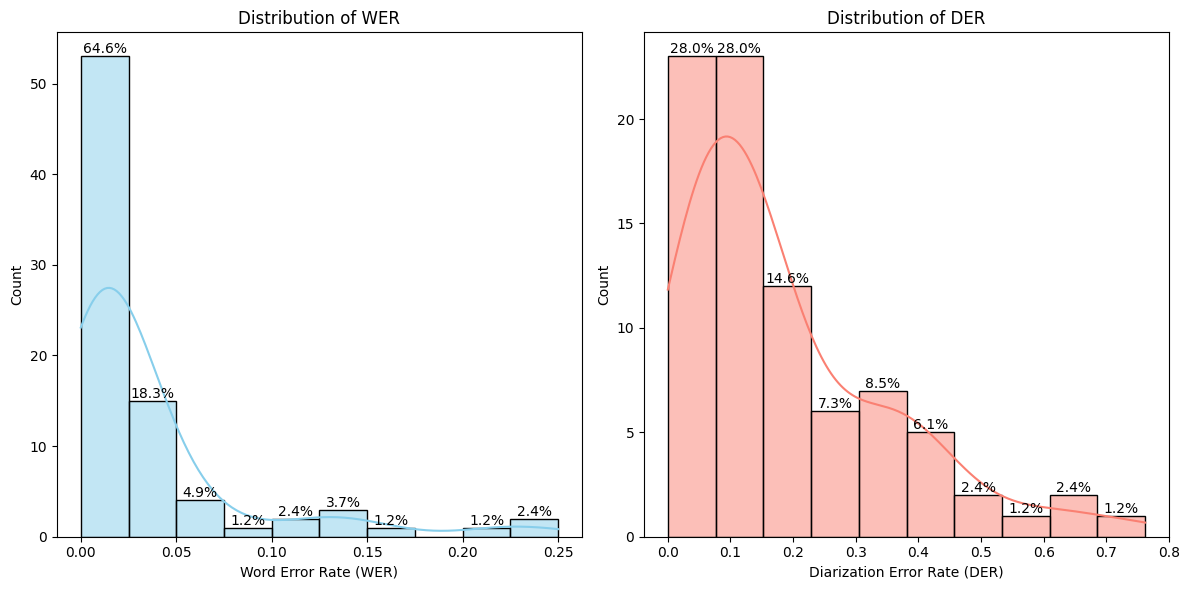

In [8]:
plot_boxplots(df_4)
plot_histograms(df_4)

# (To think about) Conventional way to calculate WER
Don't take in acount the fact that the diarization model may skip complete sentences due to bad quality of audio and overlapp & thereffore worsen unfairly the WER from the ASR.

**TODO:** *Further test with different models to try to solve this problem*

In [10]:
from evaluate import load

wer_metric = load("wer")

def calculate_wer_for_csv(hypothesis_file, reference_file):
    """
    Calculate the WER for the entire content of the 'Content' column in a CSV file.
    """
    with open(hypothesis_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        hyp = ' '.join(row['Content'] for row in reader)

    with open(reference_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        ref = ' '.join(row['Content'] for row in reader)

    return wer_metric.compute(references=[ref], predictions=[hyp])

In [11]:
reference_file= "../S301final_C.csv"
hypothesis_file  = "../results/Compassion/S301final.csv"

calculate_wer_for_csv(hypothesis_file, reference_file)

0.03026634382566586

In [12]:
hypothesis_file = "../results/Compassion/S302con.csv"
reference_file = "../S302con_C.csv"

calculate_wer_for_csv(hypothesis_file, reference_file)

0.23446893787575152

# (Useful) Problems with excel format

In [3]:
def convert_csv_semicolon_to_comma(input_file, output_file):
    """
    Converts a CSV file with semicolons as delimiters to a comma-separated CSV.
    """
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile, delimiter=';')
        writer = csv.writer(outfile, delimiter=',')
        
        for row in reader:
            writer.writerow(row)

def find_problematic_line(input_file):
    """
    Reads a file line by line to find the line that causes a UnicodeDecodeError.
    """
    with open(input_file, 'r', encoding='utf-8', errors='replace') as file:
        for line_number, line in enumerate(file, start=1):
            # If the line contains the problematic character, print the line number and content
            if '\ufffd' in line:  # '\ufffd' is the replacement character for decoding errors
                print(f"Problematic line at line {line_number}: {line}")
                break
        else:
            print("No problematic lines found.")

def remove_bom_from_file(file_path):
    """
    Removes the Byte Order Mark (BOM) from a file if it exists.
    """
    with open(file_path, 'rb') as file:
        content = file.read()

    # Check for BOM (UTF-8 BOM is \xef\xbb\xbf)
    if content.startswith(b'\xef\xbb\xbf'):
        print(f"BOM found in {file_path}, removing it...")
        content = content[3:]  # Remove the first three bytes (BOM)
        with open(file_path, 'wb') as file:
            file.write(content)
        print(f"BOM successfully removed from {file_path}.")
    else:
        print(f"No BOM found in {file_path}.")

In [6]:
file = "../performance_evaluation/references/S303man.csv"

find_problematic_line(file)

Problematic line at line 27: Compassion,S303man,303,"00:01:50,260","00:01:50,7",0,it's not�

